In [1]:
import pandas as pd
import geopandas as gpd

from fiona.drvsupport import supported_drivers


In [2]:
supported_drivers['KML'] = 'rw'



In [3]:
df = gpd.read_file('Community.kml', driver='KML')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

In [4]:
df

,Name,Description,geometry
0,kml_1,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((55.41999 25.20902 0.00000, 55.4210..."
1,kml_2,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((55.39830 25.29000 0.00000, 55.3991..."
2,kml_3,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((55.46027 25.27242 0.00000, 55.4598..."
3,kml_4,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((55.37906 25.10325 0.00000, 55.3790..."
4,kml_5,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((55.28809 25.24352 0.00000, 55.2882..."
...,...,...,...
221,kml_222,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((55.31673 25.23062 0.00000, 55.3165..."
222,kml_223,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((55.64166 25.15146 0.00000, 55.6416..."
223,kml_224,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((55.13270 25.06474 0.00000, 55.1334..."
224,kml_225,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((55.63303 25.19255 0.00000, 55.6113..."


<AxesSubplot: >

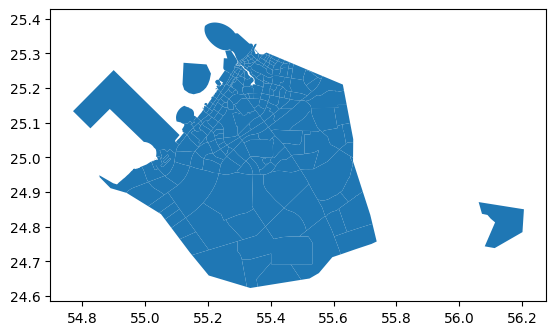

In [5]:
df.plot()

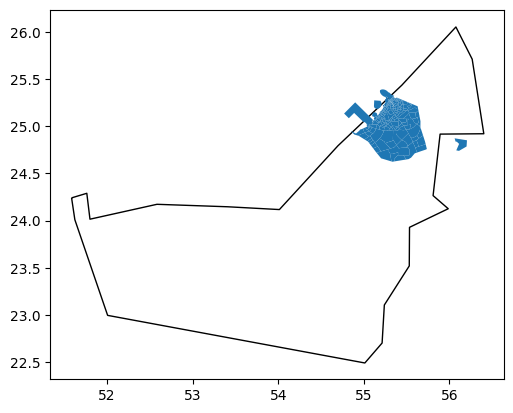

In [6]:
base = world[world.iso_a3 == 'ARE'].plot(color='white', edgecolor='black')

df.plot(ax=base);

In [7]:
gpd.tools.geocode("Dubai Silicon Oasis").explore()

In [8]:
data = pd.read_csv('transactions-2023-01-11.csv')

In [9]:
def clean_outliers_in_data(data):
    quantiles = data.quantile(0.95)
    data = data[(data['Amount'] < quantiles['Amount']) & (data['Property Size (sq.m)'] < quantiles['Property Size (sq.m)'])]
    return data

In [10]:
data = clean_outliers_in_data(data)

/var/folders/41/gxq0b1712fbb5k5ndrr4d4cw0000gn/T/ipykernel_21301/2485364952.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  quantiles = data.quantile(0.95)


In [11]:
areas = data[['Area', 'Amount']].groupby('Area').Amount.agg(['median', 'size'])
areas

,median,size
Area,,
AKOYA OXYGEN,1040000.00,3710
AL BARARI,1435909.09,768
AL FURJAN,901015.00,4530
AL KHAIL HEIGHTS,400000.00,582
AL WAHA,816000.00,128
...,...,...
Wadi Al Safa 7,538188.50,822
Wadi Alshabak,875000.00,6
Warsan First,532800.00,138


In [12]:
gpd.tools.geocode(areas.index[:50]).explore()

In [13]:
gpd.tools.geocode(areas.index[:5])['address'].iloc[0]

'Akoya Oxygen Boundary, Damac Hills Junipter, Damac Hills Junipter, دبي, الإمارات العربية المتحدة'

In [14]:
not_exist = []
merged_list = []

def merge_data_to_df(df, data, point, data_area_name):
    point_locations = df[df['geometry'].contains(point)]
    if point_locations.shape[0] > 1:
        print('!!!')
        
    if point_locations.shape[0]:
        point_location = point_locations.iloc[0]
        return {
            'data_area_name': data_area_name,
            'point': point,
            'geometry': point_location['geometry'],
            'description': point_location['Description'],
            'median_amount': data.loc[i]['median'],
            'transaction_count': data.loc[i]['size'],
        }
        
    return None

for i in areas.index:
    point = gpd.tools.geocode(i).loc[0]['geometry']
    
    point_location_object = merge_data_to_df(df, areas, point, i)
    if point_location_object:
        merged_list = merged_list + [point_location_object]
    else:
        point = gpd.tools.geocode('Dubai ' + i).loc[0]['geometry']
        point_location_object = merge_data_to_df(df, areas, point, i)
        if point_location_object:
            merged_list = merged_list + [point_location_object]
        else:
            not_exist = not_exist + [i]

In [24]:
not_exist

['Al Goze First',
 'Al Goze Fourth',
 'Al Goze Second',
 'Al Hebiah Fourth',
 'Al Hebiah Sixth',
 'Al Khabeesi',
 'Al Kheeran',
 'Al Mamzer',
 'Al Mararr',
 'Al Merkadh',
 'Al Murqabat',
 'DMCC-EZ2',
 'DUBAI WATER FRONT',
 'Eyal Nasser',
 'Lehbab Second',
 'Nadd Hessa',
 'Oud Al Muteena First',
 'Oud Al Muteena Second',
 'PALMAROSA',
 'THE VALLEY',
 'Um Nahad Fourth',
 'Um Nahad Third',
 'Wadi Alshabak',
 'Zaabeel Second']

In [15]:
areas.loc[not_exist]

,median,size
Area,,
Al Goze First,1700000.0,71
Al Goze Fourth,1935500.0,14
Al Goze Second,1000000.0,59
Al Hebiah Fourth,3048000.0,1564
Al Hebiah Sixth,2286500.0,630
Al Khabeesi,4697735.0,2
Al Kheeran,2325000.0,115
Al Mamzer,3475000.0,8
Al Mararr,3385057.0,27


In [16]:
areas_with_geometry = gpd.GeoDataFrame(merged_list)

In [17]:
areas_with_geometry

,data_area_name,point,geometry,description,median_amount,transaction_count
0,AKOYA OXYGEN,POINT (55.4034216 24.9835424),"POLYGON Z ((55.36484 24.96429 0.00000, 55.3692...",<center><table><tr><th colspan='2' align='cent...,1040000.00,3710.0
1,AL BARARI,POINT (55.30411491216756 25.096941649999998),"POLYGON Z ((55.36494 25.11990 0.00000, 55.3649...",<center><table><tr><th colspan='2' align='cent...,1435909.09,768.0
2,AL FURJAN,POINT (55.14382772063573 25.02836395),"POLYGON Z ((55.13270 25.06474 0.00000, 55.1334...",<center><table><tr><th colspan='2' align='cent...,901015.00,4530.0
3,AL KHAIL HEIGHTS,POINT (55.2536875439334 25.155860150000002),"POLYGON Z ((55.26166 25.15893 0.00000, 55.2616...",<center><table><tr><th colspan='2' align='cent...,400000.00,582.0
4,AL WAHA,POINT (55.28590170382438 25.02911295),"POLYGON Z ((55.30878 25.04939 0.00000, 55.3088...",<center><table><tr><th colspan='2' align='cent...,816000.00,128.0
...,...,...,...,...,...,...
180,Wadi Al Safa 4,POINT (55.30642610044298 25.07038905),"POLYGON Z ((55.33510 25.08278 0.00000, 55.3373...",<center><table><tr><th colspan='2' align='cent...,2000000.00,10.0
181,Wadi Al Safa 5,POINT (55.3664589 25.0795209),"POLYGON Z ((55.37906 25.10325 0.00000, 55.3790...",<center><table><tr><th colspan='2' align='cent...,3180888.00,1438.0
182,Wadi Al Safa 7,POINT (55.31581805974124 25.09985655),"POLYGON Z ((55.36494 25.11990 0.00000, 55.3649...",<center><table><tr><th colspan='2' align='cent...,538188.50,822.0
183,Warsan First,POINT (55.422077 25.1631537),"POLYGON Z ((55.40119 25.17888 0.00000, 55.4023...",<center><table><tr><th colspan='2' align='cent...,532800.00,138.0


In [18]:
grouped_areas_with_geometry = gpd.GeoDataFrame(areas_with_geometry.groupby('description', as_index=False).agg({
    'data_area_name': 'first', 
    'geometry': 'first', 
    'point': 'first', 
    'median_amount': 'median', 
    'transaction_count': 'sum'
}))

<AxesSubplot: >

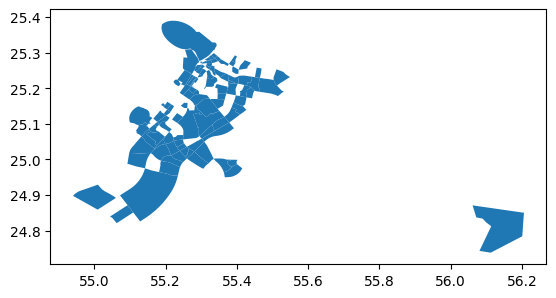

In [19]:
grouped_areas_with_geometry['geometry'].plot()

<AxesSubplot: >

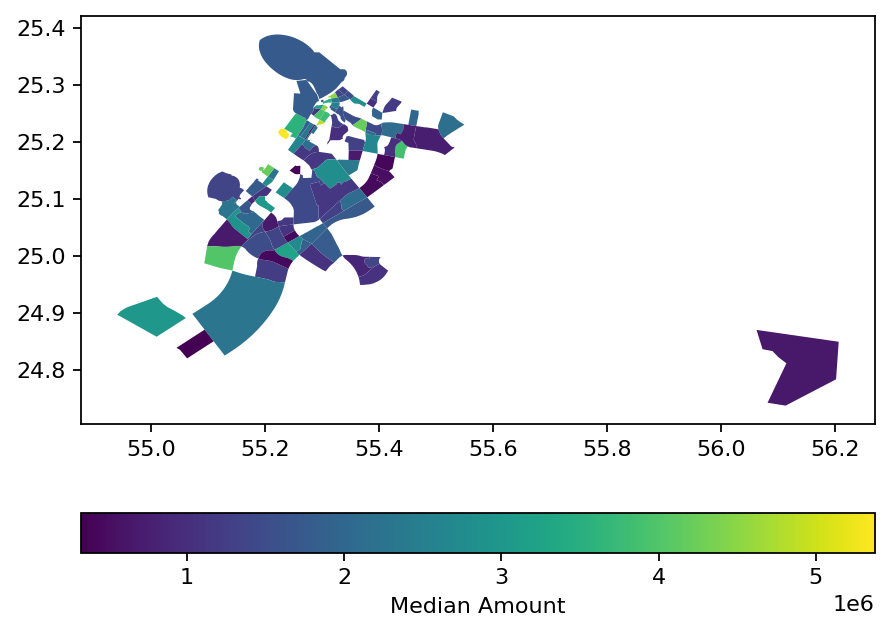

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

fig.dpi = 160

grouped_areas_with_geometry.plot(column='median_amount',
           ax=ax,
           legend=True,
           figsize=(30, 25),
           legend_kwds={'label': "Median Amount",
                        'orientation': "horizontal"})

<AxesSubplot: >

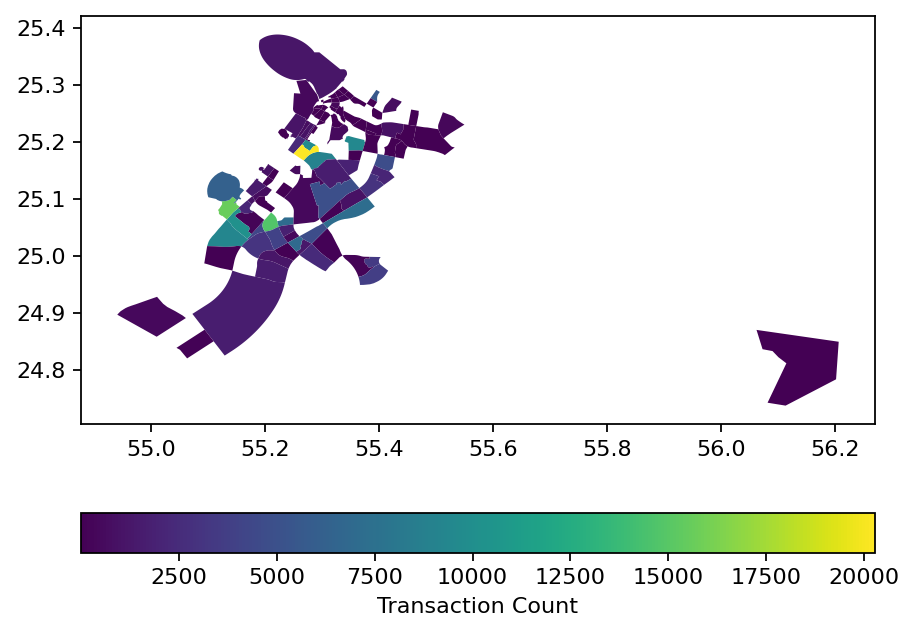

In [21]:
fig, ax = plt.subplots(1, 1)

fig.dpi = 160

grouped_areas_with_geometry.plot(column='transaction_count',
           ax=ax,
           legend=True,
           figsize=(30, 25),
           legend_kwds={'label': "Transaction Count",
                        'orientation': "horizontal"})


In [22]:
areas_with_points = gpd.GeoDataFrame({'geometry': areas_with_geometry['point'], 'median_amount': areas_with_geometry['median_amount'], 'transaction_count': areas_with_geometry['transaction_count']})


<AxesSubplot: >

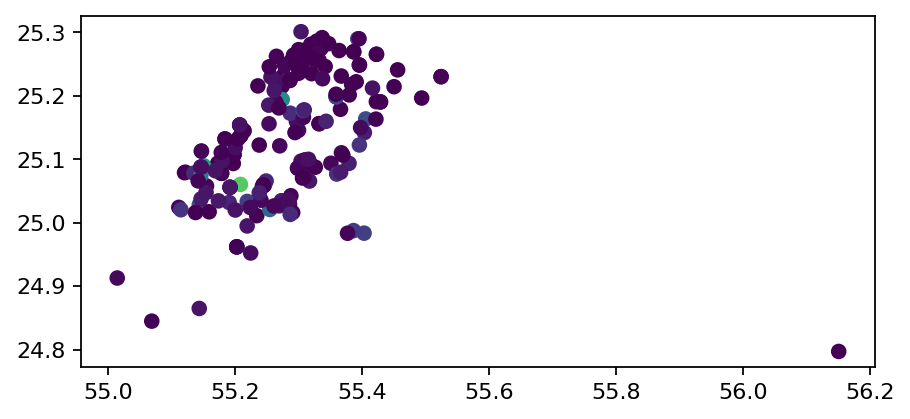

In [23]:
fig, ax = plt.subplots(1, 1)

fig.dpi = 160

areas_with_points.plot(column='transaction_count',
           ax=ax)

In [ ]:
csd